<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
     <td style="background-color:transparent;"><a href="https://www.sidetrade.com/">
<img border="0" src="https://www.sidetrade.com/wp-content/uploads/22050384_10213210110060640_1095182809_o-300x117.png" width="60%"> </td>
  </tr>
</table> 
</div>

<center><h1>FAN revenue prediction challenge</h1></center>
<br/>
<center>Lucy Liu (CDS), Maria Teleczuk (CDS), Clément Chastagnol (Sidetrade),<br /> Gael Varoquaux (Inria, Parietal), Alex Gramfort (Inria, Parietal), Guillaume Lemaitre (Scikit-learn @ Inria Foundation)</center>

Predicting revenue using French Attribution Notices: [RAMP studio challenge](https://ramp.studio/problems/fan_revenue_prediction)

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)
6. [Record linkage](#Record-linkage)
7. [Submission structure](#Submission-structure)
8. [Local testing](#Local-testing-(before-submission))
9. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))
10. [More information](#More-information)

# Introduction

The objective of this challenge is to work with 'dirty data'. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

There are two datasets in this challenge:

* `company_revenue_TRAIN.csv` - company revenue declarations.
* `award_notices_RAMP.csv` -  French Attribution Notices.

# Aim

The predictive aim of this challenge is to use `company_revenue_TRAIN.csv` and `award_notices_RAMP.csv` to predict the Revenue for each entry in the 'company financial data' dataset. It is advised that you use both datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `company_revenue_TRAIN.csv` dataset is also allowed.

# Data

## Company financial data

This dataset was built from an extract of the [National Institute of Statistics and Economic Studies (INSEE)](https://www.insee.fr/en/accueil) reference database of company revenue declarations from 2013 to 2018. Each row represents the declaration of one company for one year and the following information is provided in the columns:

* `Legal_ID` - the reconcilled legal ID of the company
* `Name` - the name of the company
* `Activity_code (APE)` - 'Activite Principale de l'Entreprise', the main activity of the company - more information in [English](https://www.startbusinessinfrance.com/code-ape) or in [French](https://www.service-public.fr/professionnels-entreprises/vosdroits/F33050)
* `Address` 
* `Zipcode`
* `City`
* `Revenue` - in Euros
* `Headcount`
* `Fiscal_year_end_date`
* `Fiscal_year_duration_in_months`
* `Year`

There are a few things to note:

* there are revenue declarations for the same company but different years
* there is a large reduction in entries for the years 2017 and 2018 due to the Loi Macron law in 2017
* the 'same company' can have several different entities, resulting in entries where the `Legal_ID` is different but the `Name`, `Address`, `City` and `Zipcode` are all the same.
* `Revenue` can be negative. A negative revenue may be due to cancelled orders from the previous fiscal year that was recorded in the current fiscal year.


## Award notices

Every French public organisation has to issue a call for tenders when buying supplies or services (above a minimum threshold). These are called public procurement contracts. Companies then compete anonymously on these contracts and when a bid is awarded, a notice has to be legally published by the public organization on the [BOAMP](https://www.boamp.fr/) (historical data is hosted by the [DILA](https://www.dila.premier-ministre.gouv.fr/)). These are called French Attribution Notices (FAN). About 25% of awards are actually electronically published.

Each contract can be divided into a maximum of 5 lots and the same company can win >1 lot of a contract. The award notices dataset comprises award notices from 2017 and 2018. Each row refers to one lot and there can be up to 5 lots referring to the same contract. The following information is provided for each lot:

* `ID_call` - ID of the award notice
* `Publication_date` of the award notice
* `End_of_call_date` of the award notice
* `Departments_of_publication` - the department code(s) of the award notice
* `Department_of_provision` - the department code(s) where the contract works/goods/services were provided 
* `Call_summary` - summary of the award notice
* `Call_title` - title of the award notice
* `Complete_call_description` - description of the award notice
* `Total_amount` - total amount of the contract, from all lots, in euros
* `CPV_classes` - Common Procurement Vocabulary (CPV), a classification system for public procurement used to describe the subject of procurement contracts (more information can be found [here](https://simap.ted.europa.eu/cpv))
Columns providing details about the company issuing the contract:
* `Buyer_name` 
* `Buyer_address`
* `Buyer_zipcode`
* `Buyer_city`
* `Buyer_email`
* `Buyer_URL`

* `Contract_awarded` - whether or not the contact was awarded

Columns providing details about the winner of each lot:

* `ID` - unique lot ID 
* `awarded` - whether or not the contact was awarded
* `description` - description of the lot
* `incumbent_name` - name of the lot winnter
* `incumbent_address` - address of the lot winner
* `incumbent_zipcode` - zipcode of the lot winner
* `incumbent_city` - city of the lot winner
* `incumbent_country` - country of the lot winner
* `number_of_received_bids` - number of bids this lot received
* `amount` - amount of the lot in euros

**Important notes**

Both data sets are very dirty. There is a lot of missing data and the column descriptions provided above are a guide only. Further, the award notices dataset is much smaller than the company revenue declarations dataset. Therefore, it is expected that many companies in the company revenue declarations dataset are not present in the award notices dataset.

## Training and test

The company revenue training dataset has been split into 'training' and 'test' subsets. The shapes are:

* training: (1 495 948, 11)
* test: (520 966, 11)

Your model will be tested on a completely separate company revenue dataset stored on the RAMP server. This dataset has a shape of (702 181, 11). This test dataset will also be dirty but we can guarantee that the following columns will (only) be of numerical data type:

* `Legal_ID`
* `Headcount`
* `Fiscal_year_duration_in_months`
* `Year`

# Score metric

A unique score is used:

$$score =  |max(5,log_{10}(max(1,y\_true))) - max(5,log_{10}(max(1,y\_pred)))| $$

Score interpretation:

* A lower score is better
* Any `y_true` or `y_pred` value less than 1 is 'taken' as 1
* If both the `y_true` and `y_pred` are less than 100 000, the score would be 0.
* The score is the same regardless of the order of `y_true` and `y_pred` in the equation.
* If the difference in raw `y_true` and `y_pred` values is the same, the score is greater for smaller magnitudes of `y_true` and `y_pred`.

# Data exploration

In [1]:
%matplotlib inline
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn

In [2]:
pd.set_option('display.max_columns', 100)

## Company financial data

In [3]:
!python download_data.py

In [91]:
from problem import get_train_data

X_df, y_array = get_train_data()

In [4]:
y_array[:10]

array([1.04334380e+08, 2.85350690e+07, 1.04817150e+07, 6.60979240e+07,
       1.52714530e+07, 4.84992327e+08, 4.76005510e+07, 8.98150730e+07,
       2.24130754e+08, 4.48039790e+07])

In [6]:
X_df.head(3)

,Legal_ID,Name,Activity_code (APE),Address,Zipcode,City,Headcount,Fiscal_year_end_date,Fiscal_year_duration_in_months,Year
0,582296,COMICOB,NaN,BOULOUPARIS BP 15 BOULOUPARIS,NaN,NaN,NaN,2016-12-31,12.0,2016.0
1,582981,CIANFARANI JEAN-MICHEL,NaN,33 AVENUE H. LAFLEUR - VICTOIRE - B.P. 4031 NO...,NaN,NaN,NaN,2016-12-31,12.0,2016.0
2,588541,OK POULET 5EME SARL,NaN,23 RUE PAUL BERT,98800.0,NOUMEA,1.0,2016-12-31,12.0,2016.0


In [7]:
X_df['Fiscal_year_end_date'] = pd.to_datetime(X_df['Fiscal_year_end_date'], format='%Y-%m-%d')

In [8]:
X_df.shape

(1495948, 10)

In [9]:
# proportion of NaN values
X_df.isna().sum() / X_df.shape[0]

Legal_ID                          0.000000
Name                              0.000002
Activity_code (APE)               0.012293
Address                           0.175296
Zipcode                           0.167944
City                              0.000313
Headcount                         0.637439
Fiscal_year_end_date              0.000000
Fiscal_year_duration_in_months    0.000000
Year                              0.000000
dtype: float64

In [10]:
# number of unique values
X_df.nunique()

Legal_ID                          563929
Name                              528646
Activity_code (APE)                  964
Address                           276152
Zipcode                             7471
City                               29498
Headcount                           2224
Fiscal_year_end_date                 300
Fiscal_year_duration_in_months         1
Year                                   6
dtype: int64

In [11]:
X_df.dtypes

Legal_ID                                   int64
Name                                      object
Activity_code (APE)                       object
Address                                   object
Zipcode                                  float64
City                                      object
Headcount                                float64
Fiscal_year_end_date              datetime64[ns]
Fiscal_year_duration_in_months           float64
Year                                     float64
dtype: object

In [12]:
X_df.describe()

,Legal_ID,Zipcode,Headcount,Fiscal_year_duration_in_months,Year
count,1.495948e+06,1.244713e+06,5.423720e+05,1495948.0,1.495948e+06
mean,5.060829e+08,5.464419e+04,8.736985e+01,12.0,2.014475e+03
std,1.417373e+08,2.755171e+04,9.002249e+03,0.0,1.246598e+00
min,5.822960e+05,6.000000e+00,-3.900000e+01,12.0,2.013000e+03
25%,4.149439e+08,3.185000e+04,1.000000e+00,12.0,2.013000e+03
50%,4.895445e+08,6.053000e+04,3.000000e+00,12.0,2.014000e+03
75%,5.293306e+08,7.511600e+04,9.000000e+00,12.0,2.015000e+03
max,9.999905e+08,9.889500e+04,5.450000e+06,12.0,2.018000e+03


### Distribution of Revenue

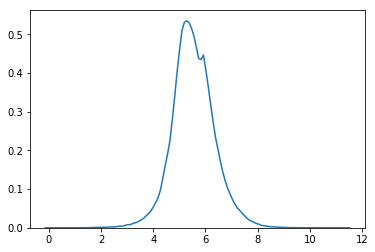

In [13]:
logRev = np.log10(np.clip(y_array, a_min=1, a_max=None))
seaborn.kdeplot(logRev)

(array([5.99887035e-02, 1.03337690e-04, 2.75958605e-04, 9.35910673e-04,
        3.07194770e-03, 9.66442263e-03, 3.00501306e-02, 1.07741285e-01,
        3.53601613e-01, 5.13703402e-01, 3.98544114e-01, 1.83874154e-01,
        6.56804965e-02, 2.16375032e-02, 5.64716992e-03, 1.65105446e-03,
        3.92213506e-04, 9.15947710e-05, 2.11372548e-05, 3.52287581e-06]),
 array([ 0.        ,  0.56925575,  1.13851149,  1.70776724,  2.27702299,
         2.84627874,  3.41553448,  3.98479023,  4.55404598,  5.12330173,
         5.69255747,  6.26181322,  6.83106897,  7.40032472,  7.96958046,
         8.53883621,  9.10809196,  9.67734771, 10.24660345, 10.8158592 ,
        11.38511495]),
 <a list of 20 Patch objects>)

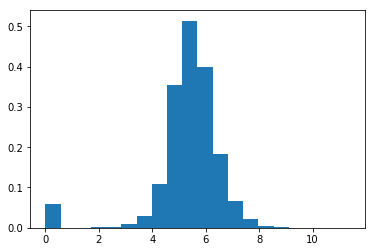

In [14]:
plt.hist(logRev, density=True, bins=20)

In [15]:
seaborn.kdeplot?

## Award notices

This dataset is present in the `data/` directory and is added by default to **all** submissions when submitting to RAMP studio. When testing your submission locally however, it is important to copy this file into the submission directory of the submission you wish to test.

For example, the starting kit submission directory (`submissions/starting_kit`) contains a copy of this dataset as it is required for RAMP to work locally. You will not need to upload this data file when you are making a submission. See for more information.

In [5]:
award = pd.read_csv('data/award_notices_RAMP.csv.zip', compression='zip')


d:\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
award[award['incumbent_name'].str.len() > 1000].iloc[0]['incumbent_name']

"ACCORD-CADRE : les 21 candidats suivants ont été référencés et seront remis en concurrence au fur et à mesure de la survenance d'un besoin de transport :- TAXI ALVES MARTINS David, 952 Chemin des Bartolots, 82000 Montauban- SARL ABC TAXIS, 525 Route de Vaïssac, 82800 Nègrepelisse- SAS T.A.T.G., 5 bis Impasse de l'Hippodrome, 82100 Castelsarrasin- SARL REGINA Hugues et MP, 23 Avenue Chamier, 82000 Montauban- TAXI MATHIEU, 2 Avenue Saturne, 82400 Valence d'Agen- SARL TRANSPORTS GERLA, Sainte-Thècle, 82200 Montesquieu- TAXI Maryline FREJABISE, Le Bourg, 82390 Durfort-Lacapelette- SARL NOUVEL HORIZON, 7 Rue de l'Haut-Blé, 59940 Neuf-Berquin- ALLO TAXI SECHER, 604 Route de Lavaur, 82370 Orgueil- SAS TRANSLOMAGNE, ZI Le Coutre, 82120 Lavit- TAXI BONJOUR, 855 Chemin du Cascaret, 82710 Bressols- SARL COMBEDOUZOU ET FILS, 254 Avenue Saint-Martin, 82150 Montaigu de Querçy- EURL AUTONOMIA TARN, 19 Avenue de la Marqueille, 31650 Saint-Orens-de-Gameville- LUCKY STAR, 22 Rue du général Paershing, 6

In [16]:
award.count()

CallID                        304093
Publication_date              304093
End_of_call_date              303943
Departments_of_publication    304093
Departments_of_provision       98950
Call_summary                  304093
Call_title                    198733
Complete_call_description     302448
Total_amount                  112126
CPV_classes                   278979
Buyer_name                    304093
Buyer_address                 298781
Buyer_zipcode                 296774
Buyer_city                    304093
Buyer_email                   254297
Buyer_URL                     239919
Contract_awarded              304093
Lot                           304098
ID                            221683
awarded                       293483
description                   148192
incumbent_name                293472
incumbent_address             261486
incumbent_zipcode             272650
incumbent_city                285463
incumbent_country             293472
number_of_received_bids       220936
a

In [17]:
award.dtypes

CallID                         object
Publication_date               object
End_of_call_date               object
Departments_of_publication     object
Departments_of_provision       object
Call_summary                   object
Call_title                     object
Complete_call_description      object
Total_amount                  float64
CPV_classes                    object
Buyer_name                     object
Buyer_address                  object
Buyer_zipcode                  object
Buyer_city                     object
Buyer_email                    object
Buyer_URL                      object
Contract_awarded               object
Lot                             int64
ID                             object
awarded                        object
description                    object
incumbent_name                 object
incumbent_address              object
incumbent_zipcode              object
incumbent_city                 object
incumbent_country              object
number_of_re

In [18]:
award.describe()

,Total_amount,Lot,number_of_received_bids,amount
count,1.121260e+05,304098.000000,220936.000000,2.159540e+05
mean,5.177948e+08,2.073213,4.606900,1.145206e+08
std,6.712391e+10,1.293831,7.982825,2.288319e+10
min,9.900000e-05,1.000000,0.000000,0.000000e+00
25%,1.967891e+05,1.000000,2.000000,3.240000e+04
50%,4.821163e+05,2.000000,3.000000,1.159775e+05
75%,1.568197e+06,3.000000,5.000000,3.674995e+05
max,1.000000e+13,5.000000,727.000000,1.000000e+13


In [19]:
# proportion of NA values
award.isna().sum() / award.shape[0]

CallID                        0.000016
Publication_date              0.000016
End_of_call_date              0.000510
Departments_of_publication    0.000016
Departments_of_provision      0.674611
Call_summary                  0.000016
Call_title                    0.346484
Complete_call_description     0.005426
Total_amount                  0.631283
CPV_classes                   0.082602
Buyer_name                    0.000016
Buyer_address                 0.017484
Buyer_zipcode                 0.024084
Buyer_city                    0.000016
Buyer_email                   0.163766
Buyer_URL                     0.211047
Contract_awarded              0.000016
Lot                           0.000000
ID                            0.271015
awarded                       0.034907
description                   0.512683
incumbent_name                0.034943
incumbent_address             0.140126
incumbent_zipcode             0.103414
incumbent_city                0.061280
incumbent_country        

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

In [54]:
award.groupby(['incumbent_country'])['incumbent_country'].count().index == 'FR'

incumbent_country
AD         2
AF         5
AL        11
AN         1
AO         1
AT        28
AU         2
BE       217
BF         1
BG         4
BR         1
CA        24
CH        98
CN         3
CZ         8
DE       253
DK        14
DZ         2
EH         1
ES       117
FI        12
FK         4
FR    289786
GA         1
GB       108
GF       136
GM         1
GP       674
GR         3
HT         1
       ...  
IT       155
JP         5
LB         1
LT         1
LU        42
LV         1
MC         7
MQ       610
MU         4
NC         5
NL       135
NO         9
NZ         1
PF        19
PL         6
PM         5
PR         1
PT        25
QA         1
RE       763
RO         8
SE        15
SG         2
SK         1
SV         2
TR         1
UK        12
US        46
YT        29
ZA         4
Name: incumbent_country, Length: 65, dtype: int64

# Predictions

## Company revenue only

First, let's predict using only the `comp` dataset:

1. Create a transformer that deals with missing values:

In [21]:
X_df.dtypes

Legal_ID                                   int64
Name                                      object
Activity_code (APE)                       object
Address                                   object
Zipcode                                  float64
City                                      object
Headcount                                float64
Fiscal_year_end_date              datetime64[ns]
Fiscal_year_duration_in_months           float64
Year                                     float64
dtype: object

In [22]:
# list of numerical columns
num_cols = ['Legal_ID', 'Headcount', 'Fiscal_year_duration_in_months', 'Year']

In [23]:

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))
])

In [88]:
cate_cols = ['a','b', 'b']

feature_preprocessor = make_column_transformer(
    (OrdinalEncoder(), cate_cols)
)
feature_preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ordinalencoder', OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), ['a', 'b', 'b'])])

In [135]:
o = OrdinalEncoder()
x = [['2'],['3'],['2']]
o.fit(x)
o.transform([['1']])

ValueError: Found unknown categories ['1'] in column 0 during transform

In [28]:
ColumnTransformer(
    transformers = [('cate', city_transformer, ['City'])]
).fit_transform(X_df)

array([[11],
       [11],
       [11],
       ...,
       [11],
       [11],
       [11]], dtype=int64)

0                           ooo
1                           ooo
2                        NOUMEA
3                        NOUMEA
4                        NOUMEA
5                        NOUMEA
6                        NOUMEA
7                        NOUMEA
8                        NOUMEA
9                        NOUMEA
10                       NOUMEA
11                          ooo
12                       NOUMEA
13                          ooo
14                         POYA
15                 NOUMEA CEDEX
16                       DUMBEA
17                          ooo
18                       DUMBEA
19                       NOUMEA
20                       NOUMEA
21                 NOUMEA CEDEX
22                    MONT DORE
23                       NOUMEA
24                       NOUMEA
25                         THIO
26                 NOUMEA CEDEX
27                 NOUMEA CEDEX
28                       NOUMEA
29                          ooo
                   ...         
1495918 

In [132]:

from sklearn.preprocessing import OrdinalEncoder
def process_City(X):
    data = X[['City']].fillna('Unknown')
    return OrdinalEncoder().fit_transform(data)
    
city_transformer = FunctionTransformer(process_City, validate=False)
city_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(fill_value='unkonwn'))
])
ColumnTransformer(
    transformers = [('cate', city_transformer, ['City'])]
).fit_transform(X_df)

#OrdinalEncoder().fit_transform(X_df[['City']])

array([[27606.],
       [27606.],
       [17519.],
       ...,
       [ 3334.],
       [ 3334.],
       [ 3334.]])

2. Create a transformer to split `Fiscal_year_end_date` into separate year, month, day columns:

In [30]:
from sklearn.preprocessing import FunctionTransformer

def process_date(X):
    date = pd.to_datetime(X['Fiscal_year_end_date'], format='%Y-%m-%d')
    return np.c_[date.dt.year, date.dt.month, date.dt.day]

date_transformer = FunctionTransformer(process_date, validate=False)

In [38]:
FunctionTransformer?

In [39]:
np.c_?

3. Process the `Activity_code (APE)` column. At the moment the Scikit learn `OrdinalEncoder()` does not have a `handle_unknown` argument. This means that it would not be able to handle any values in `Activity_code (APE)` which appear in 'train' but do not appear in 'test'. Here we will simply get around this by using the first 2 characters of `APE`, which are always numbers. The first 2 numbers give the broad category the companies activities fall under (e.g. 'AGRICULTURE'). This column is then converted to numeric data type, so missing values can be dealt with by using the median value (with `SimpleImputer()`).

In [31]:
def process_APE(X):
    APE = X['Activity_code (APE)'].str[:2]
    return pd.to_numeric(APE, errors='coerce').values[:, np.newaxis]

APE_transformer = FunctionTransformer(process_APE, validate=False)

In [85]:
round(X_df['Zipcode']/1000)

0           NaN
1           NaN
2          99.0
3          99.0
4          99.0
5          99.0
6          99.0
7          99.0
8          99.0
9          99.0
10         99.0
11          NaN
12         99.0
13          NaN
14         99.0
15         99.0
16         99.0
17          NaN
18         99.0
19         99.0
20         99.0
21         99.0
22         99.0
23         99.0
24         99.0
25         99.0
26         99.0
27         99.0
28         99.0
29          NaN
           ... 
1495918     2.0
1495919    89.0
1495920    89.0
1495921    89.0
1495922    89.0
1495923    89.0
1495924    69.0
1495925    69.0
1495926    69.0
1495927    69.0
1495928    69.0
1495929    38.0
1495930    38.0
1495931    38.0
1495932    38.0
1495933    38.0
1495934    42.0
1495935    42.0
1495936    42.0
1495937    42.0
1495938    42.0
1495939    64.0
1495940    64.0
1495941    64.0
1495942    64.0
1495943    64.0
1495944     NaN
1495945     NaN
1495946     NaN
1495947     NaN
Name: Zipcode, Length: 1

4. Only keep the numbers in the `Zipcode` column:

In [32]:
def zipcodes(X):
    
    zipcode_nums = pd.to_numeric(round(X['Zipcode']/1000), errors='coerce')
    return zipcode_nums.values[:, np.newaxis]
    
zipcode_transformer = FunctionTransformer(zipcodes, validate=False)

In [33]:
def macron(X):
    macron_binary = X['Year'].apply(lambda x : 1 if x >= 2017 else 0)
    return macron_binary.values[:, np.newaxis]
Macron_transformer = FunctionTransformer(macron, validate=False)
ColumnTransformer(
    transformers = [('cate', Macron_transformer, ['Year'])]
).fit_transform(X_df)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

72329

In [30]:
pd.to_numeric?

Finally the full pipeline is assembled. 

* for missing values in numerical columns, the 'median' is used.
* the date column `Fiscal_year_end_date` is transformed into separated year month and day columns.
* `Activity_code (APE)` is dealt with as described above.
* the columns `Name`, `Address` and `City` are all dropped.

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

zipcode_col = ['Zipcode']
date_cols = ['Fiscal_year_end_date']
drop_cols = ['Name', 'Address', 'City']
APE_col = ['Activity_code (APE)']
num_cols = ['Headcount', 'Fiscal_year_duration_in_months', 'Year']

preprocessor_comp = ColumnTransformer(
    transformers=[
        ('zipcode', make_pipeline(zipcode_transformer, SimpleImputer(strategy='median')), zipcode_col),
        ('num', numeric_transformer, num_cols),
        ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
        ('APE', make_pipeline(APE_transformer, SimpleImputer(strategy='median')), APE_col),
        ('cate', city_transformer, ['City']),
        ('drop cols', 'drop', drop_cols),
    ])


In [35]:
# make sure it works
s = preprocessor_comp.fit_transform(X_df)
print('type : ', s.dtype)
print('shape : ', s.shape)

type :  float64
shape :  (1495948, 9)


We will use a Random Forest Regressor model:

In [37]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10)

Before we can test our model, we need to define our unique scoring function:

In [36]:
from sklearn.metrics import make_scorer

def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    true = np.maximum(5., np.log10(np.maximum(1., y_true)))
    pred = np.maximum(5., np.log10(np.maximum(1., y_pred)))
    
    loss = np.mean(np.abs(true - pred))
    
    return loss
    
fan_loss = make_scorer(loss, greater_is_better=False)

Now we can test our model. Note that we use `GroupShuffleSplit` using `Legal_ID` as the group so that the same company ('Legal_ID') only appears in either 'train' or 'test' but does not appear both in 'train' **and** 'test'.

This reflects the same conditions of this challenge where, the private 'test' data (on RAMP) does not contain any company that also appears in the public 'train' dataset you have access to. This is because `Revenue` for the same company is often very similar.

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit

clf = Pipeline(steps=[
    ('preprocessing', preprocessor_comp),
    ('classifier', regressor)])


cv = GroupShuffleSplit(n_splits=2, test_size=0.25)

scores_merge = -cross_val_score(clf, X_df, y_array, cv=cv, scoring=fan_loss, groups=X_df['Legal_ID'],
                               n_jobs=2)

print("mean: %e (+/- %e)" % (scores_merge.mean(), scores_merge.std()))

d:\python36\lib\site-packages\sklearn\externals\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\Yuriko\AppData\Local\Temp\joblib_memmapping_folder_5916_9719459943 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\Yuriko\\AppData\\Local\\Temp\\joblib_memmapping_folder_5916_9719459943\\5916-1971224542792-1547bcc30f594f16914144b402aa5804.pkl'

## Naive merge

Now let us predict using a naive merge of `award` and `comp` datasets.

The naive merge will only use the name of the company. To aid the merging we will convert the name to all lower case and remove punctuation and white space.

In [59]:
award['End_of_call_date'] = pd.to_datetime(award['End_of_call_date'], errors='coerce', format='%Y-%m-%d')
award['end_year'] = award['End_of_call_date'].dt.year

In [60]:
award['Name_processed'] = award['incumbent_name'].str.lower()
award['Name_processed'] = award['Name_processed'].str.replace('[^\w]','')

In [136]:
af = award.groupby()['amount','number_of_received_bids'].agg(['count','sum'])

In [177]:
award['CPV_classes'].dropna()

0                                    71000000
1                           33696200 33696500
2                           33696200 33696500
3                           33696200 33696500
4                           33696200 33696500
5                           33696200 33696500
6                                    71336000
7                                    45233140
8         45259000 50413200 50432000 50800000
9         45259000 50413200 50432000 50800000
10        45259000 50413200 50432000 50800000
11        45259000 50413200 50432000 50800000
12        45259000 50413200 50432000 50800000
13                                   45232431
14                                   45232431
15                                   45232431
21                          44112500 45261200
23                                   30192113
24                                   60130000
25                                   22110000
26                                   22110000
27                                

In [296]:
def cpv_transform(X):
    def decompose(s):
        l = s.split()
        l = list(map(lambda x:x[:2], l))
        return ' '.join(l)
    cpvdf = award[['Name_processed','CPV_classes']].dropna()
    cpvdf_group = cpvdf.groupby('Name_processed')[['CPV_classes']].count()
    cpvdf_group['classes'] = cpvdf.groupby('Name_processed')['CPV_classes'].apply(lambda x : ' '.join(x))
    cpvdf_group['classes'] = cpvdf_group['classes'].apply(decompose)
    vectorizer = TfidfVectorizer(decode_error = 'replace')
    classvalue = vectorizer.fit_transform(cpvdf_group['classes'])
    newdf = pd.DataFrame(classvalue.toarray(), index = cpvdf_group.index)
    columns = newdf.columns
    X['Name'] = X['Name'].str.lower()     
    X['Name'] = X['Name'].str.replace('[^\w]','')
    df = pd.merge(X, newdf, left_on=['Name'], right_on=['Name_processed'], how='left')
    return df[columns]

In [293]:
cpvdf = award[['Name_processed','CPV_classes']].dropna()
cpvdf_group = cpvdf.groupby('Name_processed')[['CPV_classes']].count()

In [294]:
cpvdf_group['classes'] = cpvdf.groupby('Name_processed')['CPV_classes'].apply(lambda x : ' '.join(x))

#cpvdf['classes'] = cpvdf['classes'].apply(decompose)

KeyboardInterrupt: 

In [297]:
cpv_transform(X_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
pd.DataFrame(classvalue.toarray(), index=p.index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
Name_processed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.000000,0.0,0.224455,0.000000,0.0,0.0,0.0,0.0,0.404396,0.164300,0.000000,0.173113,0.151624,0.409908,0.0,0.0,0.0,0.144132,0.0,0.0,0.0,0.0,0.078591,0.0,0.270734,0.000000,0.000000,0.000000,0.0,0.609024,0.0,0.0,0.0,0.000000,0.161401,0.0,0.202234,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0,0.280257,0.0,0.000000,0.959925,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.781694,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.351988,0.0,0.000000,0.514839,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0000000,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
01conseilsetservicesinformatiques,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
01controle,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.629245,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.777207,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
01contrôle,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
01dbmetravibsas,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
01pompage,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
X_df.groupby('City')[['money']].mean().nlargest(50, 'money').index

Index(['MULHOUSE CEDEX 2', 'VAUCRESSON CEDEX', 'BOISSY L'AILLERIE', 'YATE',
       'VENDARGUES CEDEX', 'MARCY L'ETOILE', 'CHAUMONT', 'ST LERY', 'SOCHAUX',
       'ROCQUANCOURT', 'HENNEBONT CEDEX', 'MONTEREAU CEDEX', 'BAR SUR LOUP',
       'MAGNY LES HAMEAUX CEDEX', 'MARE', 'MARDYCK', 'MARIGNANE CEDEX',
       'ANGOULEME CEDEX 9', 'LE MESNIL ST DENIS CEDEX', 'KOUMAC',
       'MARNE LA VALLEE CEDEX 2', 'ST NAZAIRE CEDEX', 'BRIANCON', 'KONE',
       'ST OUEN CEDEX', 'COLOMBES CEDEX', 'ILLKIRCH CEDEX', 'OMEY',
       'AMBOISE CEDEX', 'VOH', 'STRASBOURG CEDEX 1', 'AMBOHIDRATRIMO',
       '92930 PARIS LA DEFENSE CED', 'THIO', 'NOUMEA CEDEX', 'BOULOUPARIS',
       'NEPOUI', 'CORBEIL ESSONNES CEDEX', 'BOURAIL', 'NANTERRE CEDEX',
       'EVRY CEDEX', 'SABLE SUR SARTHE CEDEX', 'MARLY LE ROI CEDEX',
       'HELLEMMES LILLE', 'MEUDON CEDEX', 'ETAULE', 'DRANCY CEDEX',
       'MONTPOUILLAN', 'VILLENEUVE D ASCQ CEDEX', 'ST JULIEN DE CHEDON'],
      dtype='object', name='City')

In [250]:
p.index

Index(['', '0', '00000', '0000000', '01conseilsetservicesinformatiques',
       '01controle', '01contrôle', '01dbmetravibsas', '01pompage',
       '02ingenierie',
       ...
       'étsguilbertpropreté', 'étudesetchantiersiledefrance',
       'étélaxianscommunicationsampsystèmes',
       'évehaétudesetvalorisationarchéologiques', 'évidence',
       'îledefrancediffusion', 'ôfournilgourmand', 'ömajsucule', 'ömajuscule',
       'ùarjohuntleigh'],
      dtype='object', name='Name_processed', length=107994)

In [246]:
p['a'] = p['a'].apply(decomposepose)

In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer



In [256]:
p.shape

(107994, 2)

In [144]:
X_df['Name'] =X_df['Name'].str.lower()     
X_df['Name'] =X_df['Name'].str.replace('[^\w]','')
df = pd.merge(X_df, af, left_on=['Name'], right_on=['Name_processed'], how='left')

d:\python36\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [146]:
df.columns[('amount', 'count'),
           ('amount', 'sum'),
           ('number_of_received_bids', 'sum')]

Index([                          'Legal_ID',
                                     'Name',
                      'Activity_code (APE)',
                                  'Address',
                                  'Zipcode',
                                     'City',
                                'Headcount',
                     'Fiscal_year_end_date',
           'Fiscal_year_duration_in_months',
                                     'Year',
                        ('amount', 'count'),
                          ('amount', 'sum'),
       ('number_of_received_bids', 'count'),
         ('number_of_received_bids', 'sum')],
      dtype='object')

In [145]:
df.isna().sum() / df.shape[0]

Legal_ID                            0.000000
Name                                0.000002
Activity_code (APE)                 0.012293
Address                             0.175296
Zipcode                             0.167944
City                                0.000313
Headcount                           0.637439
Fiscal_year_end_date                0.000000
Fiscal_year_duration_in_months      0.000000
Year                                0.000000
(amount, count)                     0.945737
(amount, sum)                       0.945737
(number_of_received_bids, count)    0.945737
(number_of_received_bids, sum)      0.945737
dtype: float64

(5,)


d:\python36\lib\site-packages\matplotlib\axes\_axes.py:6575: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
d:\python36\lib\site-packages\matplotlib\axes\_axes.py:6576: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: max must be larger than min in range parameter.

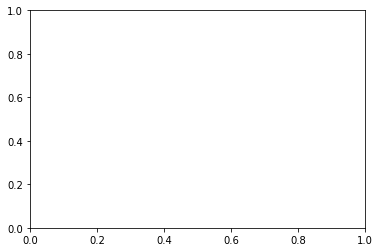

In [10]:
y = award[award['Buyer_name'] == 'ville de la Croix en Touraine']['amount']
print(y.shape)
x = [i for i in range(y.shape[0])]
plt.hist(y, bins=100)
plt.show()
plt.plot(x,y)
print(np.mean(y))

In [6]:
lyon_award = award[award['Buyer_name'] == 'DRSID Lyon']


In [8]:
lyon_award.sort_values(['amount'])

,CallID,Publication_date,End_of_call_date,Departments_of_publication,Departments_of_provision,Call_summary,Call_title,Complete_call_description,Total_amount,CPV_classes,Buyer_name,Buyer_address,Buyer_zipcode,Buyer_city,Buyer_email,Buyer_URL,Contract_awarded,Lot,ID,awarded,description,incumbent_name,incumbent_address,incumbent_zipcode,incumbent_city,incumbent_country,number_of_received_bids,amount
14309,15-132844,2015-08-28 00:00:00,2015-09-28,5,69,aménagement d'un accès pour la livraison des v...,NaN,GAP (05) - Quartier général guillaume Aménagem...,NaN,45210000,DRSID Lyon,BP 97423,69347,Lyon cedex 07,usid-grenoble.baf@defense.gouv.fr,NaN,Yes,3,3,Yes,Création d'un circuit électrique pour projecte...,INEO PACA CENTRE DE TRAVAUX VIDAL ET CIE,35 route de la Justice,05000,Gap,FR,NaN,5513.06
290363,18-66246,2018-05-16,2018-07-15,13,NaN,ESID 17-088_091 BdD ISTRES (13) - BA 125 - Tra...,NaN,ESID 17-088_091 BdD ISTRES (13) - BA 125 - Tra...,NaN,45262522 45262600 45300000 45310000 45442100,DRSID Lyon,BP 97423,69347.0,Lyon cedex 07,NaN,NaN,Yes,3,3,Yes,Travaux divers d'équipement électrique du bure...,ACCE,303 les carlues,13770,Venelles,FR,NaN,5991.00
149690,16-18882,2016-02-09 00:00:00,2016-05-08,1,01,détachement air 278-hm8-réhabilitation pour ré...,NaN,Ambérieu-en-bugey (01)- détachement air 278-HM...,NaN,45223220 45261000 45315300 45421140,DRSID Lyon,Bp 97423,69347,Lyon cedex 07,christine.cochinard@intradef.gouv.fr,NaN,Yes,4,4,Yes,Travaux d'électricité pour permettre l'aliment...,Aris sarl,5 allée des érables,69200,Vénissieux,FR,NaN,6395.21
21447,16-24841,2016-02-22 00:00:00,2016-05-14,73,73,travaux relatifs au remplacement des systèmes ...,NaN,Travaux relatifs au remplacement des systèmes ...,NaN,45343000,DRSID Lyon,BP 97423,69347,Lyon cedex 07,usid-grenoble.baf@defense.gouv.fr,NaN,Yes,3,3,Yes,Les travaux du lot no3 consistent en la réalis...,COLAS RAA,Za la pachaudiere - bp98,73203,Albertville,FR,NaN,6800.00
77260,15-133862,2015-09-01 00:00:00,2016-03-01,26,26,Fourniture et livraison de matériaux de constr...,NaN,CHABEUIL (26) - GAMSTAT - Fourniture et livrai...,NaN,44100000,DRSID Lyon,BP 97423 BP 97423,69347.0,Lyon cedex 07,eric.cianfarani@intradef.gouv.fr,NaN,Yes,2,2,Yes,Fourniture et livraison de bétons prêts à l'em...,LAFARGE Bétons France Agence Vallée du Rhône,Rue roberval - za,26000,Valence,FR,NaN,6864.00
47073,15-51146,2015-04-07 00:00:00,2015-07-03,1,01,résidence le vieux camp - villas no 34 et 36 -...,NaN,Béligneux (01) - Résidence Le Vieux Camp - Vil...,NaN,45400000,DRSID Lyon,BP 30016,1120,Dagneux montluel,christine.cochinard@intradef.gouv.fr,NaN,Yes,1,1,Yes,"Pose de clôtures, de portails et portillons",DIRICKX ESPACE CLOTURE CENTRE,"1, rue d'italie - za leopha",69780,Mions,FR,NaN,7174.25
145504,16-31251,2016-03-04 00:00:00,2016-05-30,69,69,base aérienne 942 - fort du mt verdun - rempla...,NaN,Poleymieux (69) - Base aérienne 942 - Fort du ...,NaN,45262410 45262650 45331200,DRSID Lyon,BP 97423,69347,Lyon cedex 07,eric.cianfarani@intradef.gouv.fr,NaN,Yes,3,003,Yes,Climatisation,ACOFROID,17 rue jacquard,69680,Chassieu,FR,NaN,8160.00
285074,18-8566,2018-01-19,2018-04-15,20B,NaN,VENTISERI (2B) - BA126 - Création d'un bloc sa...,NaN,VENTISERI (2B) - BA126 - Création d'un bloc sa...,NaN,45000000,DRSID Lyon,BP 97423,69347.0,Lyon cedex 07,NaN,NaN,Yes,4,4,Yes,Courant fort,GUALTIERI ELECTRICITE,Vix,20240.0,Ventiseri,FR,NaN,8700.00
171857,17-166995,2017-11-27,2018-02-01,30,NaN,Nïmes (30) - Quartier EL PARRAS - BAT 0019 (ex...,NaN,Nïmes (30) - Quartier EL PARRAS - BAT 0019 (ex...,NaN,45223220 45232141 45262660 45310000,DRSID Lyon,BP 97423,69347,Lyon cedex 07,sylvie.foulquier@intradef.gouv.fr,NaN,Yes,2,2,Yes,Retrait de matériaux contenant de l'amiante.,SARL PROVENCE Depollution,23 route de l'escale zone industrielle de snig...,30390,Domazan,FR,NaN,9350.00
155589,17-9073,2017-01-19,2017-04-15,1,NaN,BELIGNEUX (01)- Camp militaire de La Valbonne-...,NaN,BELIGNEUX (01)- Camp militaire de La Valbonne-...,NaN,45262700,DRSID Lyon,BP 97423,6

In [ ]:
award.groupby(['Buyer_name']).count().nlargest

In [147]:
df = pd.merge(X_df, award, left_on=['Name'], right_on=['Name_processed',], how='left')

In [150]:
df

In [41]:
def merge_naive(X):
    X['Name'] = X['Name'].str.lower()     
    X['Name'] = X['Name'].str.replace('[^\w]','')
    df = pd.merge(X, af, left_on=['Name','Year'], right_on=['Name_processed','end_year'], how='left')
    return df[['count','sum']]
merge_transformer = FunctionTransformer(merge_naive, validate=False)

For each company, extract 2 features:

* the number of award lots won
* the total sum of award lots won

112898   NaN
112899   NaN
112900   NaN
112901   NaN
112902   NaN
Name: amount, dtype: float64

Next we will perform a naive merge of `X_df` and `award_features`. 

Be careful in this step to ensure that the **order** of `X_df` is not changed.

In [38]:
def merge_naive(X):
    X['Name'] = X['Name'].str.lower()     
    X['Name'] = X['Name'].str.replace('[^\w]','')
    df = pd.merge(X, award_features, left_on='Name', right_on='Name_processed', how='left')
    return df[['count','sum']]
merge_transformer = FunctionTransformer(merge_naive, validate=False)

Implement the same feature transformation steps as above and include the 'merge' step.

In [43]:
zipcode_col = ['Zipcode']
date_cols = ['Fiscal_year_end_date']
drop_cols = ['Address', 'City']
APE_col = ['Activity_code (APE)']
merge_col = ['Name','Year']

preprocessor_merge = ColumnTransformer(
    transformers=[
        ('zipcode', make_pipeline(zipcode_transformer, SimpleImputer(strategy='median')), zipcode_col),
        ('num', numeric_transformer, num_cols),
        ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
        ('APE', make_pipeline(APE_transformer, SimpleImputer(strategy='median')), APE_col),
        ('merge', make_pipeline(merge_transformer, SimpleImputer(strategy='median')), merge_col),
        ('cate', city_transformer, ['City']),
        ('drop cols', 'drop', drop_cols),
    ])

In [44]:
# check it works
preprocessor_merge.fit_transform(X_df)

array([[6.0530000e+04, 3.0000000e+00, 1.2000000e+01, ..., 1.0000000e+00,
        7.2000000e+04, 1.1000000e+01],
       [6.0530000e+04, 3.0000000e+00, 1.2000000e+01, ..., 1.0000000e+00,
        7.2000000e+04, 1.1000000e+01],
       [9.8800000e+04, 1.0000000e+00, 1.2000000e+01, ..., 1.0000000e+00,
        7.2000000e+04, 1.1000000e+01],
       ...,
       [6.0530000e+04, 3.0000000e+00, 1.2000000e+01, ..., 1.0000000e+00,
        7.2000000e+04, 1.1000000e+01],
       [6.0530000e+04, 3.8400000e+02, 1.2000000e+01, ..., 1.0000000e+00,
        7.2000000e+04, 1.1000000e+01],
       [6.0530000e+04, 3.7200000e+02, 1.2000000e+01, ..., 2.0000000e+00,
        2.3689714e+05, 1.1000000e+01]])

This example is implemented in RAMP within the files in the folder `submissions/starting_kit`. 

The transformation steps above are implemented in the file `submissions/starting_kit/feature_extractor.py` (a copy of this file is shown below). This file needs to define a class called `FeatureExtractor` which requires a `fit()` and `transform()` function. The `fit()` function takes both `X_df` and `y_array` as parameters, meaning that you are able to engineer new features using `y_array` (e.g. target encoding). The `transform()` function only takes `X_df`. We only use the `transform()` function in our simple example below.

Note that the `award` dataset is being read in from the submission folder (`submissions/starting_kit`). This means that when testing locally, each submission folder should contain a copy of the award dataset `award_notices_RAMP.csv`.

In [41]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df

        path = os.path.dirname(__file__)
        award = pd.read_csv(os.path.join(path, 'award_notices_RAMP.csv.zip', compression='zip'),
                            low_memory=False)
        # obtain features from award
        award['Name_processed'] = award['incumbent_name'].str.lower()
        award['Name_processed'] = award['Name_processed'].str.replace('[^\w]','')
        award_features = award.groupby(['Name_processed'])['amount'].agg(['count','sum'])
        
        def process_City(X):
            good_citys = ['MULHOUSE CEDEX 2', 'VAUCRESSON CEDEX', 'BOISSY L'AILLERIE', 'YATE',
               'VENDARGUES CEDEX', 'MARCY L'ETOILE', 'CHAUMONT', 'ST LERY', 'SOCHAUX',
               'ROCQUANCOURT', 'HENNEBONT CEDEX', 'MONTEREAU CEDEX', 'BAR SUR LOUP',
               'MAGNY LES HAMEAUX CEDEX', 'MARE', 'MARDYCK', 'MARIGNANE CEDEX',
               'ANGOULEME CEDEX 9', 'LE MESNIL ST DENIS CEDEX', 'KOUMAC',
               'MARNE LA VALLEE CEDEX 2', 'ST NAZAIRE CEDEX', 'BRIANCON', 'KONE',
               'ST OUEN CEDEX', 'COLOMBES CEDEX', 'ILLKIRCH CEDEX', 'OMEY',
               'AMBOISE CEDEX', 'VOH', 'STRASBOURG CEDEX 1', 'AMBOHIDRATRIMO',
               '92930 PARIS LA DEFENSE CED', 'THIO', 'NOUMEA CEDEX', 'BOULOUPARIS',
               'NEPOUI', 'CORBEIL ESSONNES CEDEX', 'BOURAIL', 'NANTERRE CEDEX',
               'EVRY CEDEX', 'SABLE SUR SARTHE CEDEX', 'MARLY LE ROI CEDEX',
               'HELLEMMES LILLE', 'MEUDON CEDEX', 'ETAULE', 'DRANCY CEDEX',
               'MONTPOUILLAN', 'VILLENEUVE D ASCQ CEDEX', 'ST JULIEN DE CHEDON']
            return X['City'].apply(lambda x : good_citys.index(x) if x in good_citys else len(good_citys)).values[:, np.newaxis]
        city_transformer = FunctionTransformer(process_City, validate=False)

        def zipcodes(X):
            zipcode_nums = pd.to_numeric(X['Zipcode'], errors='coerce')
            return zipcode_nums.values[:, np.newaxis]
        zipcode_transformer = FunctionTransformer(zipcodes, validate=False)

        numeric_transformer = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median'))])

        def process_date(X):
            date = pd.to_datetime(X['Fiscal_year_end_date'], format='%Y-%m-%d')
            return np.c_[date.dt.year, date.dt.month, date.dt.day]
        date_transformer = FunctionTransformer(process_date, validate=False)
        
        def process_APE(X):
            APE = X['Activity_code (APE)'].str[:2]
            return pd.to_numeric(APE).values[:, np.newaxis]
        APE_transformer = FunctionTransformer(process_APE, validate=False)

        def merge_naive(X):
            X['Name'] = X['Name'].str.lower()     
            X['Name'] = X['Name'].str.replace('[^\w]','')
            df = pd.merge(X, award_features, left_on='Name', 
                          right_on='Name_processed', how='left')
            return df[['count','sum']]
        merge_transformer = FunctionTransformer(merge_naive, validate=False)

        num_cols = ['Legal_ID', 'Headcount', 
                    'Fiscal_year_duration_in_months', 'Year']
        zipcode_col = ['Zipcode']
        date_cols = ['Fiscal_year_end_date']
        APE_col = ['Activity_code (APE)']
        merge_col = ['Name']
        drop_cols = ['Address', 'City']

        preprocessor = ColumnTransformer(
            transformers=[
                ('zipcode', make_pipeline(zipcode_transformer, SimpleImputer(strategy='median')), zipcode_col),
                ('num', numeric_transformer, num_cols),
                ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
                ('APE', make_pipeline(APE_transformer, SimpleImputer(strategy='median')), APE_col),
                ('merge', make_pipeline(merge_transformer, SimpleImputer(strategy='median')), merge_col),
                ('cate', city_transformer, ['City']),
                ('drop cols', 'drop', drop_cols),
                ])

        X_array = preprocessor.fit_transform(X_encoded)
        return X_array

We will use a Random Forest Regressor model again:

In [145]:
regressor = RandomForestRegressor(n_estimators=10)

This is implemented in the file `submissions/starting_kit/regressor.py` (a copy of this file is shown below). The `Regressor` class must have a `fit()` and `predict()` function. If you are using a scikit-learn function, this can be done by simply calling `fit()` and `predict()` on the regressor, as seen below.

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

We can test our model within this notebook, using `preprocessor_merge` and `regressor` defined above, in a `Pipeline()`. 

Once you are happy with a solution, you can transfer your solution to `feature_extractor.py` and `regressor.py` files and test your submission using RAMP (see 'Submissions').

In [46]:
from sklearn.svm import SVR
regressor = SVR()

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit

clf = Pipeline(steps=[
    ('preprocessing', preprocessor_merge),
    ('classifier', regressor)])

cv = GroupShuffleSplit(n_splits=8, test_size=0.25)

scores_merge = -cross_val_score(clf, X_df, y_array, cv=cv, scoring=fan_loss, groups=X_df['Legal_ID'],
                               n_jobs=2)

print("mean: %e (+/- %e)" % (scores_merge.mean(), scores_merge.std()))

d:\python36\lib\site-packages\sklearn\externals\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\Yuriko\AppData\Local\Temp\joblib_memmapping_folder_5916_9719459943 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\Yuriko\\AppData\\Local\\Temp\\joblib_memmapping_folder_5916_9719459943\\5916-1971224542792-1547bcc30f594f16914144b402aa5804.pkl'

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(shuffle=True)
grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3, return_train_score=True)
grid.fit(X, y)

## Score comparison

You can see in the below plot of the scores that using the merged data always results in better scores (smaller is better):

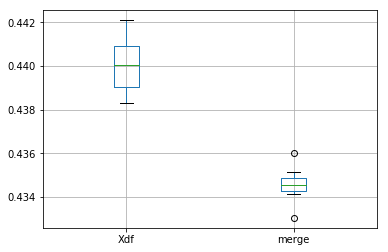

In [37]:
scores = pd.DataFrame({'Xdf': scores_Xdf, 'merge': scores_merge})
scores.boxplot()

# Record linkage

The problem of trying to match 'records' referring to the same entity across different data sources is called  record linkage. We used a very naive way to match companies above but there are much more sophiisticated methods and packages implementing these methods. To get you started here are two Python packages:

* [Python Record Linkage Toolkit](https://recordlinkage.readthedocs.io/en/latest/index.html)
* [Dedupe](https://github.com/dedupeio/dedupe)

# Submission structure

Each of your submissions should be in it's own folder within the `submissions` folder (e.g. `submissions/my_submission`). The submission directory should contain 3 files:

* a copy of the `award_notices_RAMP.csv` dataset. Note that you will **not** need to upload this file when making a submission in RAMP studio as this is done automatically by RAMP studio.
* `feature_extractor.py` - this should merge the `X_df` and the award dataset and any feature transformation you wish
* `regressor.py` - this should implement a regressor with a `fit()` and `predict()` function

See `submissions/starting_kit` for an example.

You can also test your submissions using RAMP-workflow before submitting:

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test - `ramp_test_submission`. 

First, ensure that `ramp-worflow` is installed (see the [github repo](https://github.com/paris-saclay-cds/ramp-workflow) for installation instructions). 

Now you can use `ramp_test_submission`. This command will test on files in [`submissions/starting_kit`](/submissions/starting_kit) by default. To specify testing on a different folder use the flag `--submission`. For example to run the test on `submissions/solution1` use: `ramp_test_submission --submission solution1`.

If it runs and print training and test errors on each fold, then you can submit the code.

For example, below we test the starting kit:

In [3]:
!ramp_test_submission

Testing Prediction of annual revenue using FAN
Reading train and test files from ./data ...


Traceback (most recent call last):
  File "d:\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\python36\Scripts\ramp_test_submission.exe\__main__.py", line 7, in <module>
  File "d:\python36\lib\site-packages\rampwf\utils\command_line.py", line 104, in ramp_test_submission
    retrain=retrain)
  File "d:\python36\lib\site-packages\rampwf\utils\testing.py", line 89, in assert_submission
    X_train, y_train, X_test, y_test = assert_data(ramp_kit_dir, ramp_data_dir)
  File "d:\python36\lib\site-packages\rampwf\utils\testing.py", line 44, in assert_data
    X_train, y_train = problem.get_train_data(path=ramp_data_dir)
  File ".\problem.py", line 62, in get_train_data
    return _read_data(path, f_name)
  File ".\problem.py", line 55, in _read_data
    compression='zip')
  File "d:\python36\lib\site-packages\pandas\io\parsers.py", line 678, in parser_f
    retur

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then sign up for the 'FAN_revenue_prediction' challenge and the 'Saclay M2 Data Camp 2019/20' [event](https://ramp.studio/events/fan_revenue_prediction_saclay_datacamp_19). Both signups are controlled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://ramp.studio/events/fan_revenue_prediction_saclay_datacamp_19/sandbox). Here you can either edit and save the code files on the left hand side of the page or upload your `feature_extractor.py` and `regressor.py` files on the right hand side of the page, then give your submission a name and click 'submit'. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://ramp.studio/events/fan_revenue_prediction_saclay_datacamp_19/my_submissions). Once it is trained, you get an email, and your submission shows up on the [public leaderboard](https://ramp.studio/events/fan_revenue_prediction_saclay_datacamp_19/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](https://ramp.studio/events/fan_revenue_prediction_saclay_datacamp_19/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_ then check that your submission works locally with `ramp_test_submission`. The script will print mean cross-validation scores if your submission works.

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](https://ramp.studio/events/fan_revenue_prediction_saclay_datacamp_19/leaderboard)) is `FAN error`.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).